## Import necessary libraries

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LearningRateScheduler
import time
import datetime

In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load dataset
df = pd.read_csv(r"E:\Seraj\racism_xenophobia_data_comments_labeled.csv")

## Data preprocessing

In [4]:
# Filter and preprocess data
filtered_df = df[df['comment'].str.len() >= 30].copy()
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.dropna(inplace=True)

In [5]:
# Preprocessing function
def preprocess_text(text, use_lemmatization=True):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove Emails
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Handling negations
    processed_tokens = []
    i = 0
    while i < len(filtered_tokens):
        if filtered_tokens[i] == 'not' and i + 1 < len(filtered_tokens):
            processed_tokens.append('not_' + filtered_tokens[i + 1])
            i += 2  # Skip the next word since it's combined
        else:
            processed_tokens.append(filtered_tokens[i])
            i += 1

    # Lemmatization
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        processed_tokens = [lemmatizer.lemmatize(token) for token in processed_tokens]

    return " ".join(processed_tokens)

In [6]:
# Apply preprocessing
filtered_df['processed_comments'] = filtered_df['comment'].apply(preprocess_text)
filtered_df['label'] = filtered_df['label'].astype(int)

In [7]:
# Adjust labels
mapping_dict = {1: 0, 2: 1}
filtered_df['label'] = filtered_df['label'].replace(mapping_dict)

In [8]:
# Oversample the entire dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(filtered_df['processed_comments'].values.reshape(-1, 1), filtered_df['label'])

# Convert resampled data to the correct format
X_resampled_flat = X_resampled.flatten()

In [9]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_flat, y_resampled, test_size=0.2, random_state=42, shuffle=True)

In [10]:
# Define parameters
max_tokens = 7000
max_len = 700

# Tokenize the data
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [11]:
# Load GloVe embeddings
def load_glove_embeddings(filepath, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

embedding_dim = 100
embedding_matrix = load_glove_embeddings('glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

# Build the model
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=embedding_dim, 
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                            trainable=False)

## Model architecture

In [12]:
# Define a function for learning rate scheduling
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

In [13]:
# Build the model architecture
model = Sequential([
    embedding_layer,
    Conv1D(32, 5, activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [14]:
# Compile the model with the initial learning rate
initial_lr = 5e-4
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping, learning rate reduction, and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

## Train the model

In [15]:
start_training_time = time.time()
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_test_pad, y_test),
                    epochs=40,
                    batch_size=256,
                    callbacks=[early_stopping, reduce_lr])
end_training_time = time.time()
training_time = end_training_time - start_training_time

# Convert training time to hours, minutes, and seconds
training_time_delta = datetime.timedelta(seconds=training_time)
print(f"Total training time: {training_time_delta}")


Epoch 1/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 56s 251ms/step - accuracy: 0.5112 - loss: 1.8198 - val_accuracy: 0.6086 - val_loss: 1.2391 - learning_rate: 5.0000e-04
Epoch 2/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 59s 314ms/step - accuracy: 0.5539 - loss: 1.2198 - val_accuracy: 0.6040 - val_loss: 0.9876 - learning_rate: 5.0000e-04
Epoch 3/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 56s 296ms/step - accuracy: 0.6318 - loss: 0.9161 - val_accuracy: 0.6706 - val_loss: 0.8317 - learning_rate: 5.0000e-04
Epoch 4/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 52s 276ms/step - accuracy: 0.6845 - loss: 0.7676 - val_accuracy: 0.7097 - val_loss: 0.7118 - learning_rate: 5.0000e-04
Epoch 5/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 48s 255ms/step - accuracy: 0.7269 - loss: 0.6754 - val_accuracy: 0.7425 - val_loss: 0.6282 - learning_rate: 5.0000e-04
Epoch 6/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.7654 - loss: 0.6059 - val_accuracy: 0.7675 - val_loss: 0.5827 - learning_rate: 5.0000e-04
Epoch 7/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 56s 29

## Evaluate

In [16]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8925 - loss: 0.4440
Test Loss: 0.42802608013153076
Test Accuracy: 0.8983373045921326


In [17]:
# Generate classification report
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

378/378 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      6013
           1       0.85      0.97      0.91      6076

    accuracy                           0.90     12089
   macro avg       0.91      0.90      0.90     12089
weighted avg       0.91      0.90      0.90     12089



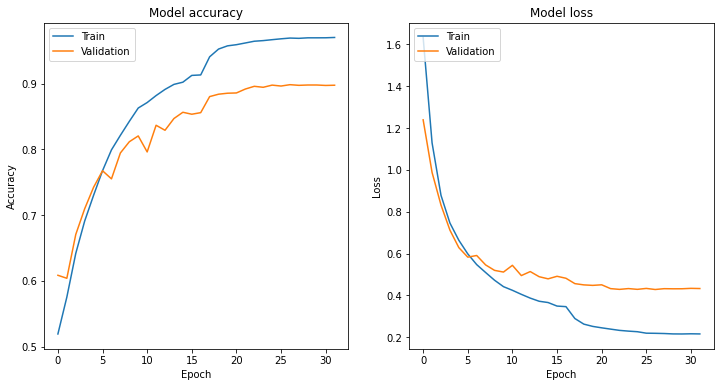

In [18]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Prediction

In [19]:
# Prediction functions
def preprocess_single_sentence(sentence, tokenizer, max_len, use_lemmatization=True):
    sentence = preprocess_text(sentence, use_lemmatization)
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    return padded_sequence

def predict_and_time(sentences, model, tokenizer, max_len, batch_size=32):
    input_data = np.vstack([preprocess_single_sentence(sentence, tokenizer, max_len) for sentence in sentences])
    
    start_time = time.time()
    predictions = model.predict(input_data, batch_size=batch_size)
    end_time = time.time()
    
    inference_time = end_time - start_time
    
    results = []
    for prediction in predictions:
        predicted_probability = prediction[0] * 100
        predicted_class = int(prediction[0] > 0.5)
        class_description = "Xenophobic statements" if predicted_class == 1 else "Racism"
        results.append((predicted_probability, class_description))
    
    return results, inference_time

In [20]:
sentences = ["The color of your skin determines your worth.", "Foreigners steal our jobs and resources."]
results, inference_time = predict_and_time(sentences, model, tokenizer, max_len)

# Print predictions and inference time
for i, (predicted_probability, class_description) in enumerate(results):
    print(f"Sentence {i+1}:")
    print(f"  Predicted probability: {predicted_probability:.2f}%")
    print(f"  Class description: {class_description}")
print(f"Total inference time for {len(sentences)} sentences: {inference_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sentence 1:
  Predicted probability: 96.93%
  Class description: Xenophobic statements
Sentence 2:
  Predicted probability: 97.57%
  Class description: Xenophobic statements
Total inference time for 2 sentences: 0.1048 seconds


In [22]:
model.save('model.keras')